# Régressions Ridge, Lasso et Elastic net

## Imports

In [1]:
data <- read.csv("../data/support2.csv")
head(data)

,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,⋯,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
,<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>
1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,11,⋯,1.1999512,141,7.459961,NA,NA,NA,7,7,,7
2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12,⋯,5.5000000,132,7.250000,NA,NA,NA,NA,1,<2 mo. follow-up,1
3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12,⋯,2.0000000,134,7.459961,NA,NA,NA,1,0,<2 mo. follow-up,0
4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,11,⋯,0.7999268,139,NA,NA,NA,NA,0,0,no(M2 and SIP pres),0
5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,NA,⋯,0.7999268,143,7.509766,NA,NA,NA,NA,2,no(M2 and SIP pres),2
6,93.01599,1,male,1,4,4,Coma,Coma,1,14,⋯,0.6999512,140,7.659180,NA,NA,NA,NA,1,<2 mo. follow-up,1


## Cleaning

In [2]:
data$pafi[is.na(data$pafi)] <- 333.3
data$alb[is.na(data$alb)] <- 3.5
data$bun[is.na(data$bun)] <- 6.51
data$urine[is.na(data$urine)] <- 2502

In [3]:
data <- data[, !names(data) %in% "dnr"]
data <- data[, !names(data) %in% "scoma"]
data <- data[, !names(data) %in% "sps"]
data <- data[, !names(data) %in% "surv2m"]
data <- data[, !names(data) %in% "surv6m"]

head(data)

,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,⋯,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
,<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>
1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,11,⋯,1.1999512,141,7.459961,NA,6.51,2502,7,7,,7
2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12,⋯,5.5000000,132,7.250000,NA,6.51,2502,NA,1,<2 mo. follow-up,1
3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12,⋯,2.0000000,134,7.459961,NA,6.51,2502,1,0,<2 mo. follow-up,0
4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,11,⋯,0.7999268,139,NA,NA,6.51,2502,0,0,no(M2 and SIP pres),0
5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,NA,⋯,0.7999268,143,7.509766,NA,6.51,2502,NA,2,no(M2 and SIP pres),2
6,93.01599,1,male,1,4,4,Coma,Coma,1,14,⋯,0.6999512,140,7.659180,NA,6.51,2502,NA,1,<2 mo. follow-up,1


In [4]:
data[] <- lapply(data, function(x) {
  if (is.numeric(x)) {
    x[is.na(x)] <- median(x, na.rm = TRUE)
  }
  return(x)
})
head(data)

,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,⋯,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
,<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,11,⋯,1.1999512,141,7.459961,135,6.51,2502,7,7,,7
2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12,⋯,5.5000000,132,7.250000,135,6.51,2502,0,1,<2 mo. follow-up,1
3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12,⋯,2.0000000,134,7.459961,135,6.51,2502,1,0,<2 mo. follow-up,0
4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,11,⋯,0.7999268,139,7.419922,135,6.51,2502,0,0,no(M2 and SIP pres),0
5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,12,⋯,0.7999268,143,7.509766,135,6.51,2502,0,2,no(M2 and SIP pres),2
6,93.01599,1,male,1,4,4,Coma,Coma,1,14,⋯,0.6999512,140,7.659180,135,6.51,2502,0,1,<2 mo. follow-up,1


In [5]:
colonnes_chaine <- sapply(data, is.character)

nombres_vides <- sapply(data[, colonnes_chaine], function(x) sum(x == ""))

# Afficher les résultats
resultats <- data.frame(
  colonne = names(nombres_vides),
  nombre_vides = nombres_vides
)
resultats

,colonne,nombre_vides
,<chr>,<int>
sex,sex,0
dzgroup,dzgroup,0
dzclass,dzclass,0
income,income,2982
race,race,42
ca,ca,0
sfdm2,sfdm2,1400


In [6]:
data <- data[, !names(data) %in% "income"]
#data <- data[, !names(data) %in% "sfdm2"]
data <- data[!(is.na(data$sfdm2) | data$sfdm2 == ""), ]
data <- data[!(is.na(data$race) | data$race == ""), ]
data <- data[!(is.na(data$dnr) | data$dnr == ""), ]

colonnes_chaine <- sapply(data, is.character)

nombres_vides <- sapply(data[, colonnes_chaine], function(x) sum(x == ""))

# Afficher les résultats
resultats <- data.frame(
  colonne = names(nombres_vides),
  nombre_vides = nombres_vides
)
resultats

,colonne,nombre_vides
,<chr>,<int>
sex,sex,0
dzgroup,dzgroup,0
dzclass,dzclass,0
race,race,0
ca,ca,0
sfdm2,sfdm2,0


On applique un poids aux personnes qui meurent car il y en a moins dans le dataset

In [7]:
A <- ifelse(data$hospdead > 0.5, 1, 0)
A <- A[A == 1]
B <- ifelse(data$hospdead < 0.5, 1, 0)
B <- B[B == 1]

A_t = length(A)/nrow(data)
B_t = length(B)/nrow(data)

inv_At = 1/A_t *B_t
inv_Bt = 1

inv_At

[1] 2.325823

On sépare en gardant la même proportion de morts/vivants

In [8]:
library(caret)

set.seed(123)
index <- createDataPartition(data$hospdead, p = 0.7, list = FALSE)

train_data2 <- data[index, ]
test_data2 <- data[-index, ]

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : lattice



On applique arbitrairement 2 fois plus d'importance aux faux positifs qu'aux négatifs

In [9]:
weights <- ifelse(train_data2$hospdead == 1, 1, inv_At * 2)

In [10]:
library(glmnet)


Le chargement a nécessité le package : Matrix



Loaded glmnet 4.1-8



## Ridge et Lasso

In [11]:
formula <- hospdead ~ . - 1

x_train <- model.matrix(formula, data = train_data2)
y_train <- train_data2$hospdead

x_test <- model.matrix(formula, data = test_data2)
y_test <- test_data2$hospdead

## Ridge

In [12]:
ridge_model <- glmnet(x_train, y_train, family = "binomial", alpha = 0)

cv_ridge <- cv.glmnet(x_train, y_train, family = "binomial", alpha = 0)

best_lambda_ridge <- cv_ridge$lambda.min

final_ridge_model <- glmnet(x_train, y_train, family = "binomial", alpha = 0, lambda = best_lambda_ridge, weights = weights)

In [13]:
ridge_preds <- predict(final_ridge_model, s = best_lambda_ridge, newx = x_test, type = "response")
ridge_classes <- ifelse(ridge_preds > 0.5, 1, 0)

conf_matrix_ridge <- table(Actual = y_test, Predicted = ridge_classes)

In [14]:
print("Confusion Matrix for Ridge:")
print(conf_matrix_ridge)

accuracy_ridge <- sum(diag(conf_matrix_ridge)) / sum(conf_matrix_ridge)

print(paste("Accuracy for Ridge:", accuracy_ridge))

[1] "Confusion Matrix for Ridge:"
      Predicted
Actual    0    1
     0 1604   14
     1  317  367


[1] "Accuracy for Ridge: 0.856211989574283"


On obtient ici une précision de 86% pour la régression Ridge avec un nombre minimal de faux positifs

`geom_smooth()` using formula = 'y ~ x'


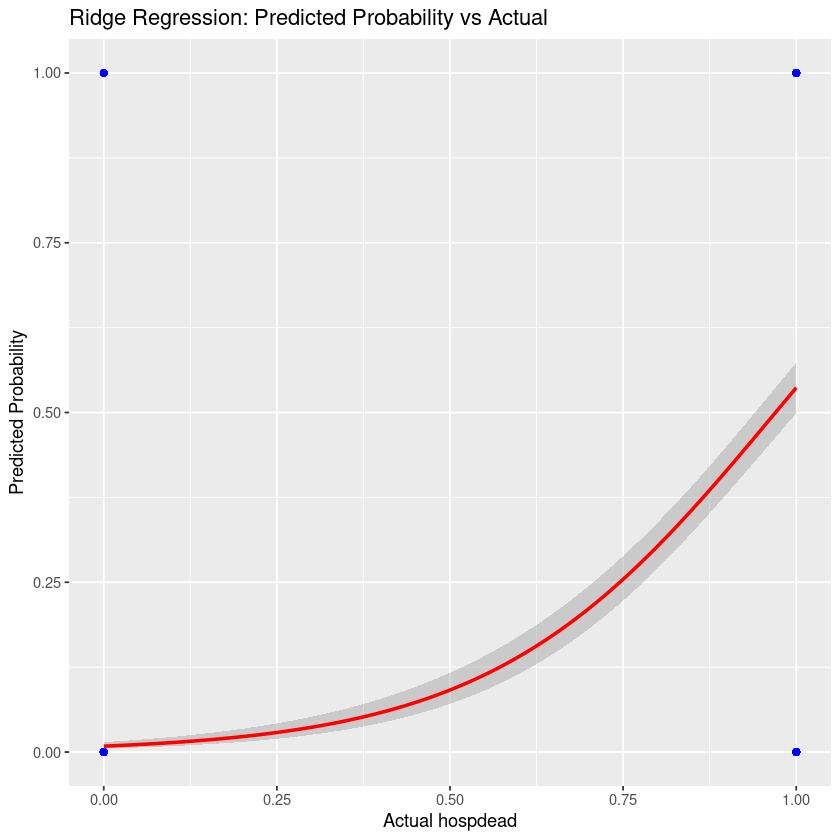

In [20]:
ridge_plot_data <- data.frame(
  Actual = y_test,
  Predicted = as.numeric(ridge_classes)
)

ggplot(ridge_plot_data, aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_smooth(method = "glm", method.args = list(family = "binomial"), color = "red") +
  ggtitle("Ridge Regression: Predicted Probability vs Actual") +
  xlab("Actual hospdead") +
  ylab("Predicted Probability")

## Lasso

In [15]:
final_lasso_model <- glmnet(x_train, y_train, family = "binomial", alpha = 1, weights = weights)

Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


In [16]:
#best_lambda_lasso <- final_lasso_model$lambda.min
arg_min <- which.min(final_lasso_model$lambda)
best_lambda_lasso <- final_lasso_model[[5]][arg_min]
#arg_min <- which(final_lasso_model$lambda == best_lambda_lasso)

final_lasso_model <- glmnet(x_train, y_train, family = "binomial", alpha = 1, lambda = best_lambda_lasso, weights = weights)

In [17]:
final_lasso_model


Call:  glmnet(x = x_train, y = y_train, family = "binomial", weights = weights,      alpha = 1, lambda = best_lambda_lasso) 

  Df  %Dev    Lambda
1 50 84.49 8.858e-05

In [18]:
lasso_preds <- predict(final_lasso_model,s = best_lambda_lasso, newx = x_test, type = "response")
lasso_classes <- ifelse(lasso_preds > 0.5, 1, 0)

conf_matrix_lasso <- table(Actual = y_test, Predicted = lasso_classes)

In [19]:
print("Confusion Matrix for Lasso:")
print(conf_matrix_lasso)

accuracy_lasso <- sum(diag(conf_matrix_lasso)) / sum(conf_matrix_lasso)

print(paste("Accuracy for Lasso:", accuracy_lasso))

[1] "Confusion Matrix for Lasso:"
      Predicted
Actual    0    1
     0 1583   35
     1   77  607
[1] "Accuracy for Lasso: 0.951346655082537"


Ici on obtient une précision de 95%, mais en ayant un peu plus de faux positifs que pour la régression Ridge.

`geom_smooth()` using formula = 'y ~ x'


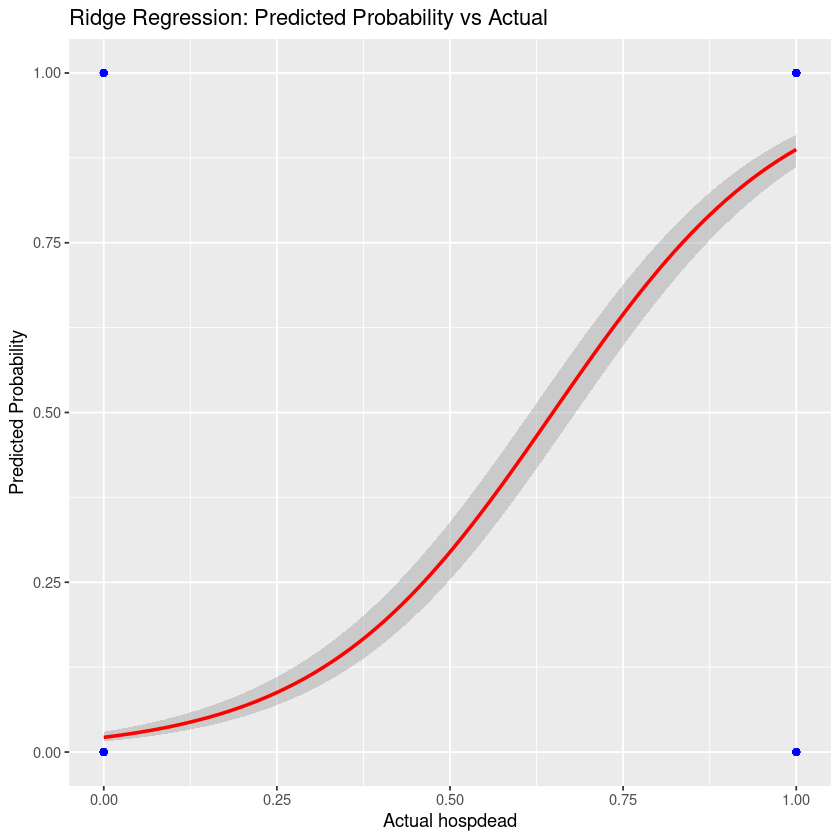

In [21]:
ridge_plot_data <- data.frame(
  Actual = y_test,
  Predicted = as.numeric(lasso_classes)
)

ggplot(ridge_plot_data, aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_smooth(method = "glm", method.args = list(family = "binomial"), color = "red") +
  ggtitle("Ridge Regression: Predicted Probability vs Actual") +
  xlab("Actual hospdead") +
  ylab("Predicted Probability")

## Elastic Net

In [23]:
res <- c()

for (i in 0:10) {
cv_model <- cv.glmnet(
  x_train, y_train,
  alpha = i/10,  # Mélange entre Ridge et Lasso
  family = "binomial",  # Régression logistique
  weights = weights  # Poids pour équilibrer
)

# Extraction du lambda optimal
optimal_lambda <- cv_model$lambda.min
cat("Lambda optimal :", optimal_lambda, "\n")

# Prédictions sur l'ensemble de test
predictions <- predict(cv_model, x_test, s = "lambda.min", type = "response")
predicted_classes <- ifelse(predictions > 0.5, 1, 0)

# Évaluation des performances
confusion_matrix <- table(Actual = y_test, Predicted = predicted_classes)
print(confusion_matrix)

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
cat(accuracy)
res <- c(res, (accuracy))
}


Lambda optimal : 0.01144041 
      Predicted
Actual    0    1
     0 1596   22
     1  273  411
0.8718506Lambda optimal : 0.0001144041 
      Predicted
Actual    0    1
     0 1583   35
     1  204  480
0.8961772Lambda optimal : 5.720206e-05 
      Predicted
Actual    0    1
     0 1584   34
     1  190  494
0.9026933Lambda optimal : 3.813471e-05 
      Predicted
Actual    0    1
     0 1584   34
     1  181  503
0.906603Lambda optimal : 2.860103e-05 
      Predicted
Actual    0    1
     0 1585   33
     1  170  514
0.9118158Lambda optimal : 2.288082e-05 
      Predicted
Actual    0    1
     0 1583   35
     1  156  528
0.9170287Lambda optimal : 1.906735e-05 
      Predicted
Actual    0    1
     0 1583   35
     1  150  534
0.9196351Lambda optimal : 1.634345e-05 
      Predicted
Actual    0    1
     0 1584   34
     1  123  561
0.9317984Lambda optimal : 1.722502e-05 
      Predicted
Actual    0    1
     0 1584   34
     1  120  564
0.9331017Lambda optimal : 2.024041e-05 
      Pre

Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; s

Lambda optimal : 8.857896e-05 
      Predicted
Actual    0    1
     0 1582   36
     1   77  607
0.9509123

On voit ici que dès que alpha vaut $0.1$ ou plus, le nombre de faux positifs reste le même (50% plus élevé que pour Ridge) et ce n'est que le nombre de faux négatifs qui diminue

D'un autre côté, la précision globale augmente avec le alpha, ce qui signifie que la précision optimale est obtenue avec Lasso

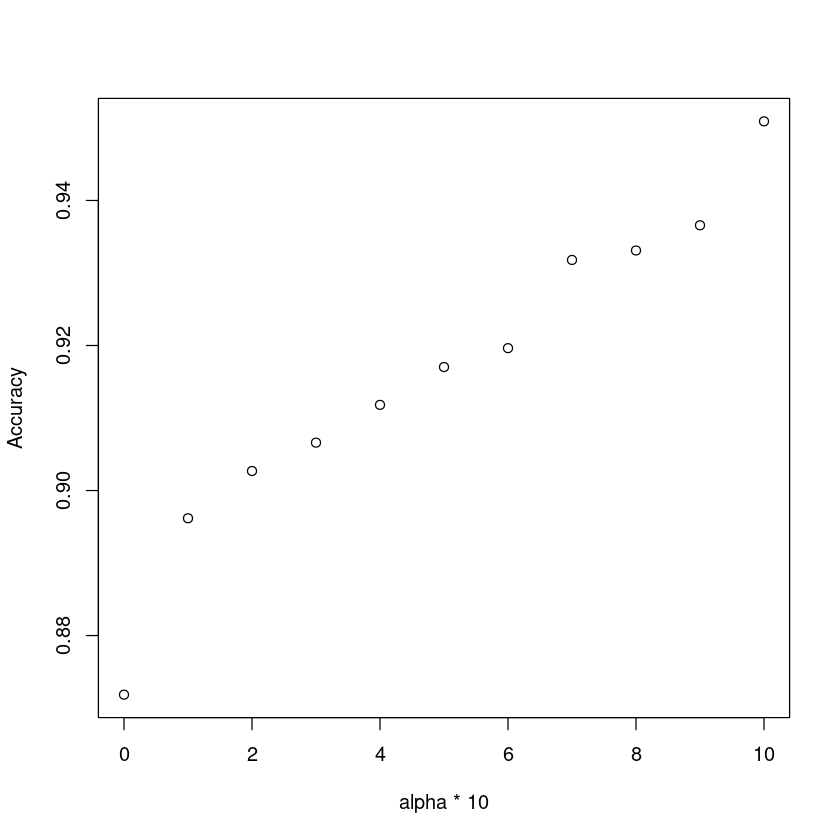

In [26]:
plot(x=0:10, y = res, xlab="alpha * 10", ylab="Accuracy")